# Setup

In [1]:
import pymongo
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import timedelta
from iso8601 import parse_date
import csv

sns.set_theme(style="darkgrid")

season_start = parse_date("2019-06-15T02:50:01.334Z")
season_end = parse_date("2019-07-12T00:15:59.024Z")

client = pymongo.MongoClient()
db = client.tpp3
collection = db.matches.find({"finished_at": {"$gt": season_start, "$lt": season_end}})
data = pd.DataFrame(list(collection))
keys = list(data.keys())
to_drop = ["game","avatars","teams","base_metagames","base_gimmicks"]
for i in to_drop:
    if i in keys:
        data = data.drop([i], axis=1)

data.result = pd.to_numeric(data.result, errors="coerce")

data["duration"] = data.finished_at - data.started_at
data = data.drop(["started_at","finished_at","created_at"],axis=1)

data[["odds","blue_odds"]] = pd.DataFrame(data.pokeyen_odds.to_list(), index=data.index)
data["winner_odds"] = [data.odds[i] if result==1 else data.blue_odds[i] for i,result in enumerate(data["result"])]
data = data.drop(["pokeyen_odds","blue_odds"],axis=1)

data["num_bettors"] = data.pokeyen_bets.str.len() # magic I guess
data = data.drop(["pokeyen_bets"], axis=1)

# TODO there has to be a better way
average_bet = []
total_bonus = []
collection = db.matches.find({"finished_at": {"$gt": season_start, "$lt": season_end}}) # it broke without resetting collection here
for i, match in enumerate(collection):
    if len(match["pokeyen_bets"]) == 0:
        average_bet.append(0.0)
        total_bonus.append(0.0)
    else:
        average_bet.append(statistics.mean(bet["amount"] for bet in match["pokeyen_bets"].values()))
        total_bonus.append((sum(bet["amount"]*bet["bet_bonus"]/100 for bet in match["pokeyen_bets"].values()
                                if bet["team"] == match["result"] and "bet_bonus" in bet)))
data["average_bet"] = pd.DataFrame(average_bet)
if len(total_bonus) == len(average_bet):
    data["bet_bonus_amount"] = pd.DataFrame(total_bonus)
del average_bet

keys = list(data.keys())
should_draw_metagames = "metagame" in keys
should_draw_gimmicks = "gimmick" in keys
should_draw_bonus = "bet_bonus_amount" in keys



nonzero_bets = data[data.average_bet > 0]

data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3881 entries, 0 to 3880
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   _id               3881 non-null   int64          
 1   result            3858 non-null   float64        
 2   stage             3881 non-null   object         
 3   metagame          3881 non-null   object         
 4   gimmick           3881 non-null   object         
 5   switching         3881 non-null   object         
 6   custom            3881 non-null   bool           
 7   result_overrides  5 non-null      object         
 8   duration          3881 non-null   timedelta64[ns]
 9   odds              3881 non-null   float64        
 10  winner_odds       3881 non-null   float64        
 11  num_bettors       3881 non-null   int64          
 12  average_bet       3881 non-null   float64        
 13  bet_bonus_amount  3881 non-null   float64        
dtypes: bool(

,_id,result,stage,metagame,gimmick,switching,custom,result_overrides,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
0,120755,0.0,sunset,pwt,normal,always,False,NaN,0 days 00:02:49.500000,0.369972,2.702909,39,734.410256,1834.366872
1,120756,0.0,main_street,simple,hidden_ace,always,False,NaN,0 days 00:06:18.784000,1.235085,0.809661,37,730.027027,3111.027559
2,120757,1.0,lagoon,runmons,commitment,never,True,NaN,0 days 00:04:13.737000,1.985081,1.985081,35,828.914286,1038.105867
3,120758,0.0,gateway,stadium2,hidden_ace,always,False,NaN,0 days 00:05:15.425000,0.617116,1.620440,30,687.166667,2232.737186
4,120759,1.0,magma,advanced,normal,never,False,NaN,0 days 00:04:21.391000,2.008759,2.008759,36,801.500000,1342.498562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3876,124631,0.0,crystal,stadium2,pinpoint,always,False,NaN,0 days 00:04:46.880000,0.489809,2.041614,36,1603.944444,3456.165300
3877,124632,0.0,main_street,simple,doubles_defiance_combo_of_2,never,False,NaN,0 days 00:06:39.577000,0.358761,2.787369,41,4028.097561,4716.780822
3878,124633,1.0,lagoon,advanced,normal,always,False,NaN,0 days 00:03:44.395000,1.708801,1.708801,40,3785.550000,15686.578680
3879,124634,1.0,lagoon,runmons,doubles,never,False,NaN,0 days 00:05:32.225000,2.881409,2.881409,46,6413.521739,6518.096431


# Highlights 

### Match with the least bidders

In [2]:
data[data.num_bettors == data.num_bettors.min()]

,_id,result,stage,metagame,gimmick,switching,custom,result_overrides,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
1357,122112,1.0,sunset,ubers,80_perc_hp,never,False,NaN,0 days 00:08:07.171000,1.000000e-30,1.000000e-30,0,0.0,0.0
1358,122113,1.0,magma,simple,acid_rain,never,False,NaN,0 days 00:06:26.879000,1.000000e-30,1.000000e-30,0,0.0,0.0


### Match with the lowest average bet

In [3]:
data[data.average_bet == data.average_bet.min()]

,_id,result,stage,metagame,gimmick,switching,custom,result_overrides,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
1357,122112,1.0,sunset,ubers,80_perc_hp,never,False,NaN,0 days 00:08:07.171000,1.000000e-30,1.000000e-30,0,0.0,0.0
1358,122113,1.0,magma,simple,acid_rain,never,False,NaN,0 days 00:06:26.879000,1.000000e-30,1.000000e-30,0,0.0,0.0


### Match with the lowest Red odds

In [4]:
data[data.odds == data.odds.max()]

,_id,result,stage,metagame,gimmick,switching,custom,result_overrides,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
2347,123102,1.0,main_street,simple,acid_rain,never,False,NaN,0 days 00:03:55.800000,4671.090909,4671.090909,10,5139.3,2729.351111


### Match with the most bidders

In [5]:
data[data.num_bettors == data.num_bettors.max()]

,_id,result,stage,metagame,gimmick,switching,custom,result_overrides,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
3880,124635,1.0,waterfall,ubers,duel,never,True,NaN,0 days 00:04:57.822000,0.468787,0.468787,59,5358.033898,2233.828954


### Match with the highest average bet

In [6]:
data[data.average_bet == data.average_bet.max()]

,_id,result,stage,metagame,gimmick,switching,custom,result_overrides,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
3354,124109,1.0,gateway,random_mix_bid3,doubles,never,True,NaN,0 days 00:01:51.501000,994.060556,994.060556,21,85290.904762,0.0


### Match with the highest red odds

In [7]:
data[data.odds == data.odds.min()]

,_id,result,stage,metagame,gimmick,switching,custom,result_overrides,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
327,121082,0.0,sunset,random_mix_auto,doubles,always,False,NaN,0 days 00:10:09.510000,1.000000e-30,1.000000e-30,2,245.500000,47.329675
1357,122112,1.0,sunset,ubers,80_perc_hp,never,False,NaN,0 days 00:08:07.171000,1.000000e-30,1.000000e-30,0,0.000000,0.000000
1358,122113,1.0,magma,simple,acid_rain,never,False,NaN,0 days 00:06:26.879000,1.000000e-30,1.000000e-30,0,0.000000,0.000000
1360,122115,NaN,magma,simple,singles_combo_of_4,never,True,"[{'timestamp': 2019-06-24 13:26:52.822000, 'us...",0 days 00:14:33.177000,1.000000e-30,1.000000e-30,1,200.000000,0.000000
3504,124259,1.0,sunset,random_mix_bid3,blind_bet,never,True,NaN,0 days 00:01:22.604000,1.000000e-30,1.000000e-30,3,397.666667,0.000000


# Data over time

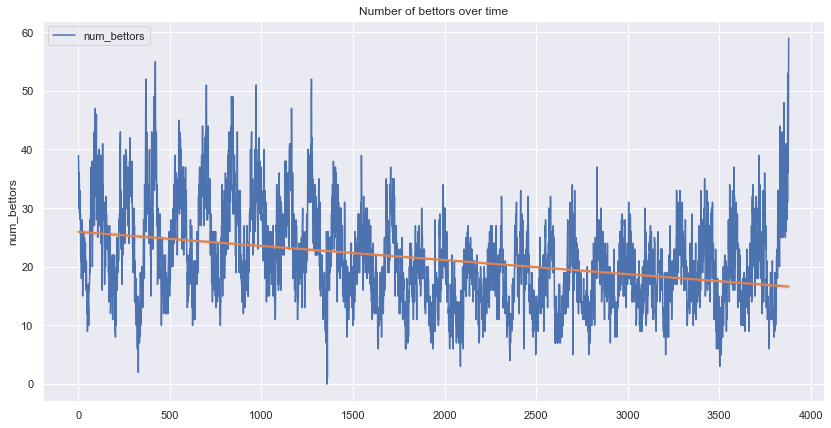

In [8]:
ax = data.plot(y="num_bettors",figsize=(14,7), title="Number of bettors over time")
sns.regplot(x=data.index, y=data.num_bettors, scatter=False, ax=ax)
# sns.kdeplot(y=data.num_bettors)
plt.show()

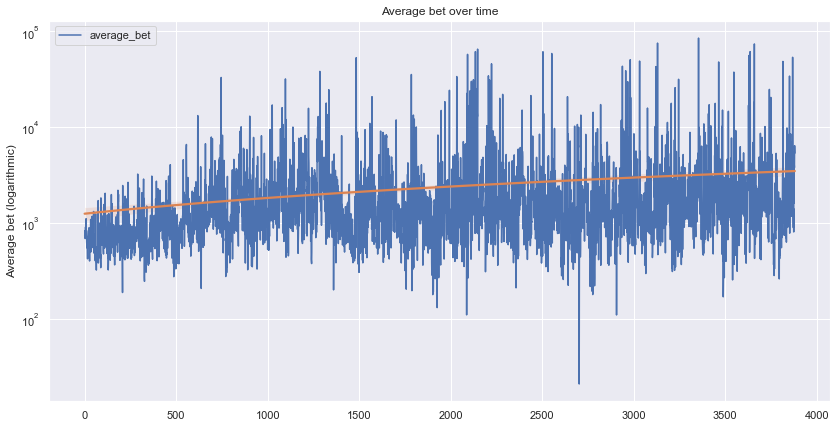

In [9]:
ax = nonzero_bets.plot(y="average_bet", logy=True, figsize=(14,7), title="Average bet over time")
sns.regplot(x=nonzero_bets.index, y=nonzero_bets.average_bet, scatter=False, ax=ax)
ax.set(ylabel="Average bet (logarithmic)")
plt.show()

<Figure size 432x288 with 0 Axes>

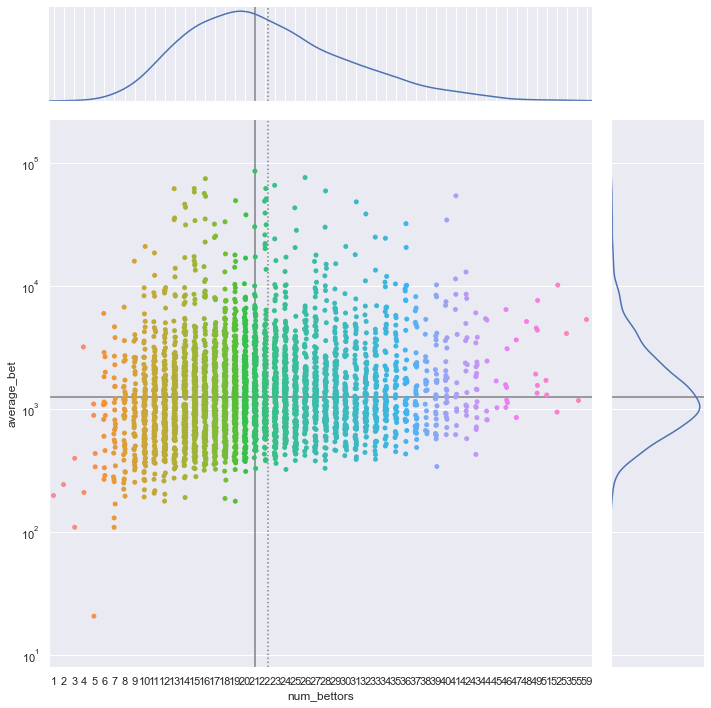

<Figure size 432x288 with 0 Axes>

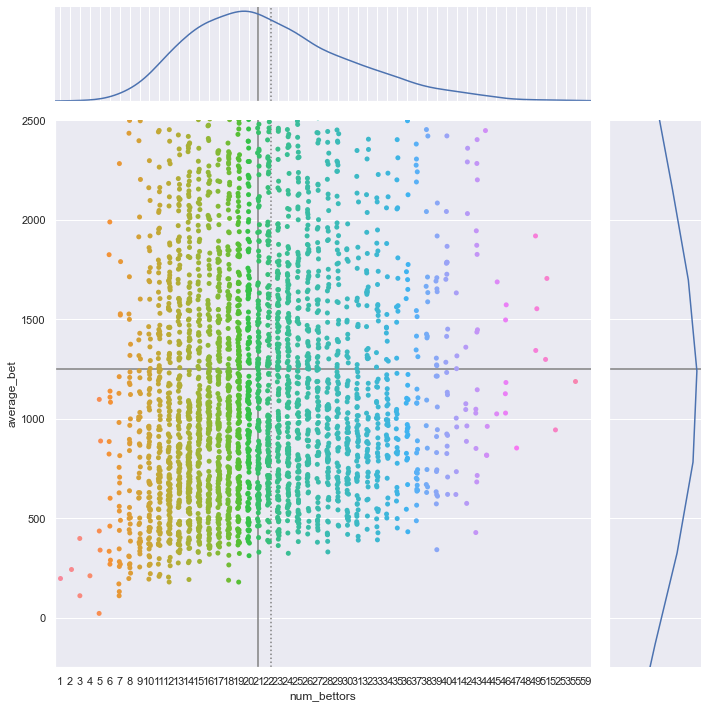

In [10]:
def fill_plot():
    g.refline(x=x.mean(), linestyle=":")
    g.refline(x=x.median(), y=y.median(), linestyle="-")
    sns.stripplot(x=x, y=y, s=5, ax=g.ax_joint)
    sns.kdeplot(x=x, ax=g.ax_marg_x)
    sns.kdeplot(y=y, ax=g.ax_marg_y)
    plt.xticks(rotation=90)
    
x, y = nonzero_bets.num_bettors, nonzero_bets.average_bet

f = plt.figure()
g = sns.JointGrid(x=x, y=y,
                   xlim=(nonzero_bets.num_bettors.min()-1,nonzero_bets.num_bettors.max()+1),
                   height=10,
                  )
g.ax_joint.set_yscale("log")
fill_plot()

median_thresh = y.median() * 2
if(y.max() > median_thresh * 10):
    f = plt.figure()
    g = sns.JointGrid(x=x, y=y,
                    xlim=(nonzero_bets.num_bettors.min()-1,nonzero_bets.num_bettors.max()+1),
                    height=10,
                    ylim=((-0.1*median_thresh),median_thresh)
                  )
    fill_plot()

plt.show()

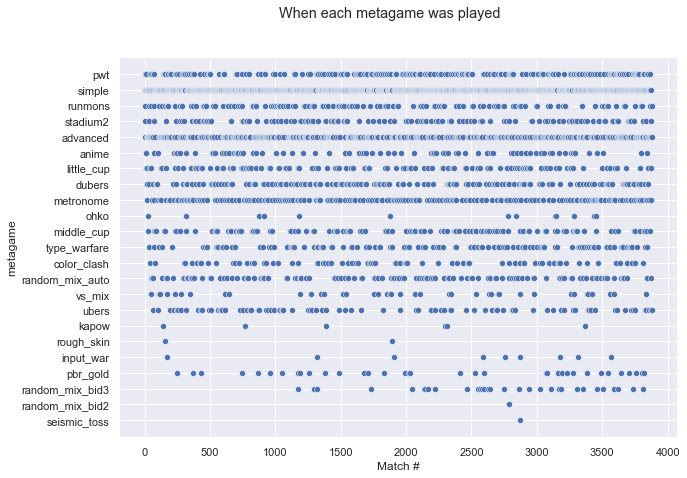

In [11]:
if should_draw_metagames:
    f = plt.figure(figsize=(10,7))
    f.suptitle("When each metagame was played")
    ax = sns.scatterplot(x=data.index,y=data.metagame)
    ax.set(xlabel="Match #")
    plt.show()
else:
    print("No metagames this season :(")

# Metagames

## Setup

In [12]:
if should_draw_metagames:
    threshold = 0.005 * data.index.max() # remove metagames that appear less than this amount of times, since they are likely token matches
    meta = nonzero_bets[nonzero_bets.groupby("metagame").metagame.transform("count") > threshold]
    metagames = nonzero_bets.metagame.unique().tolist()
    for m in meta.metagame.unique().tolist():
        metagames.remove(m)
    print("removed very rare metagames: " + str(metagames))

removed very rare metagames: ['ohko', 'kapow', 'rough_skin', 'input_war', 'random_mix_bid2', 'seismic_toss']


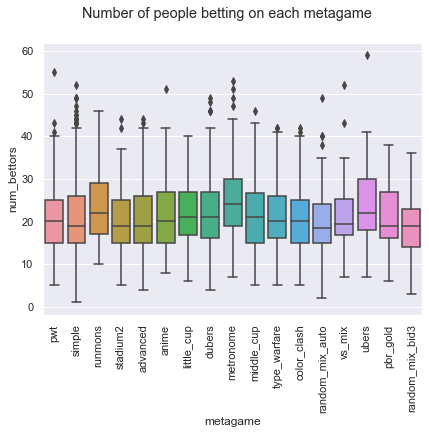

In [13]:
if should_draw_metagames:
    f = plt.figure(figsize=(len(meta.metagame.unique())/2.5,5))
    f.suptitle("Number of people betting on each metagame")
    sns.boxplot(x=meta.metagame, y=meta.num_bettors)
    plt.xticks(rotation=90)
    plt.show()

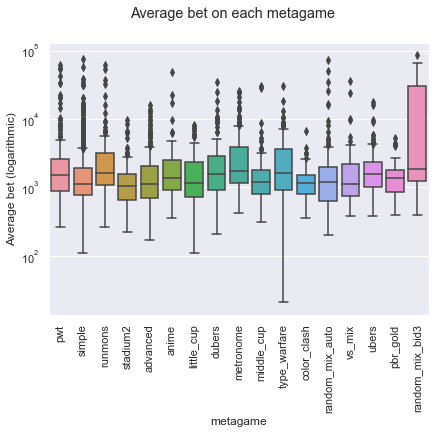

In [14]:
if should_draw_metagames:
    f = plt.figure(figsize=(len(meta.metagame.unique())/2.5,5))
    f.suptitle("Average bet on each metagame")
    ax = sns.boxplot(x=meta.metagame,y=meta.average_bet)
    ax.set(yscale="log", ylabel="Average bet (logarithmic)")
    plt.xticks(rotation=90)
    plt.show()

# Gimmicks

## Setup

In [15]:
if should_draw_gimmicks:
    threshold_gim = 5 # absolute minimum amount of data we need to make any meaningful insight
    gim = nonzero_bets[nonzero_bets.groupby("gimmick").gimmick.transform("count") > threshold_gim]
    gimmicks = data.gimmick.unique().tolist()
    for g in gim.gimmick.unique().tolist():
        gimmicks.remove(g)
    print("removed infrequently used gimmicks: " + str(gimmicks))
else:
    print("no gimmicks this season :(")

removed infrequently used gimmicks: ['italian', 'shield', 'letdown', 'defiance_rngod', 'fire_and_ice', 'armor', 'spanish', 'french', 'rngod', 'boing']


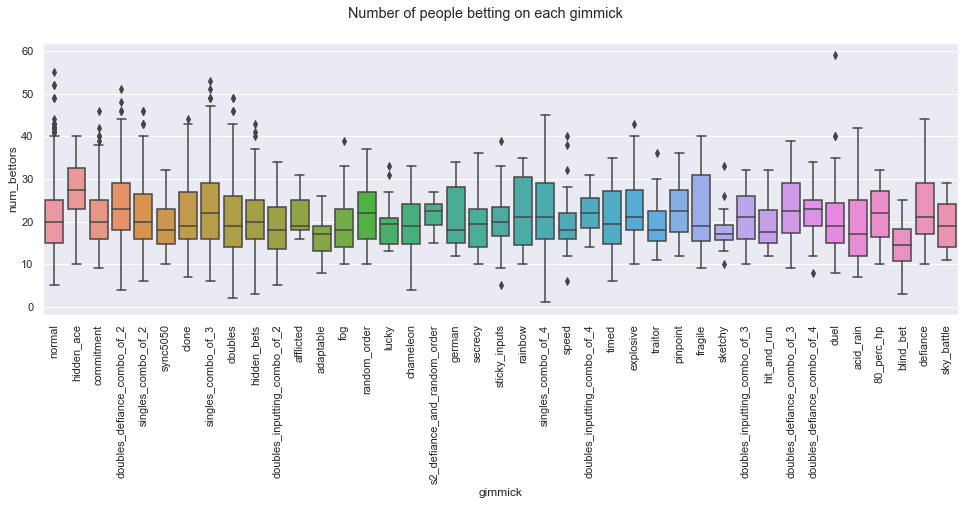

In [16]:
if should_draw_gimmicks:
    f = plt.figure(figsize=(len(gim.gimmick.unique())/2.5,5))
    f.suptitle("Number of people betting on each gimmick")
    sns.boxplot(x="gimmick",y="num_bettors",data=gim)
    plt.xticks(rotation=90)
    plt.show()

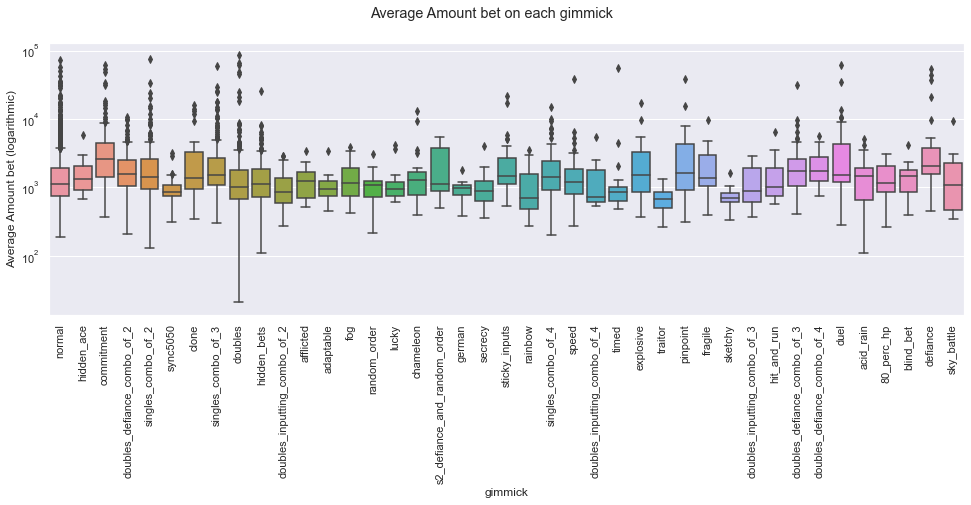

In [17]:
if should_draw_gimmicks:
    f = plt.figure(figsize=(len(gim.gimmick.unique())/2.5,5))
    f.suptitle("Average Amount bet on each gimmick")
    ax = sns.boxplot(x=gim.gimmick, y=gim.average_bet)
    ax.set(yscale="log", ylabel="Average Amount bet (logarithmic)")
    plt.xticks(rotation=90)
    plt.show()

# Switching

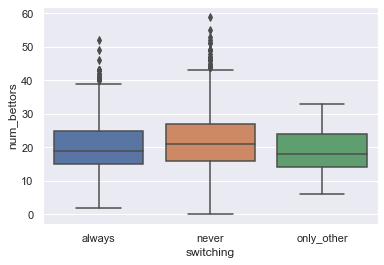

In [18]:
sns.boxplot(x=data.switching,y=data.num_bettors)
plt.show()

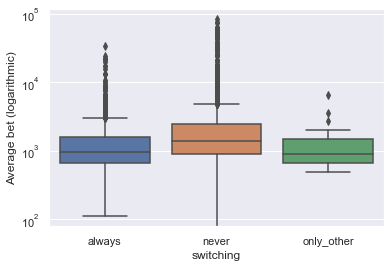

In [19]:
ax = sns.boxplot(x=data.switching,y=data.average_bet)
ax.set(yscale="log", ylabel="Average bet (logarithmic)")
plt.show()

# Odds vs winner
lower odds(<1) indicate more people bet on team 0 (probably red?), while higher(>1) odds indicate more people bet on team 1 (probably blue) 

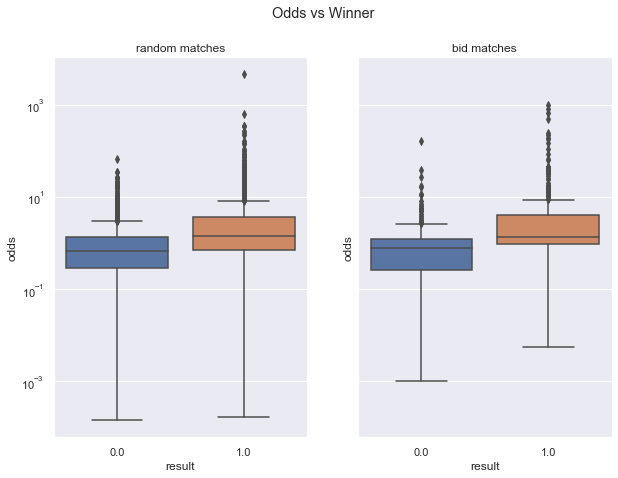

In [20]:
# remove entries where bets are all on 1 team
nonzero_bets = nonzero_bets[nonzero_bets.odds > 0.00001]

auto_matches = nonzero_bets[nonzero_bets.custom == False]
bid_matches = nonzero_bets[nonzero_bets.custom == True]

f, ax = plt.subplots(1, 2, figsize=(10,7),sharey=True)
f.suptitle("Odds vs Winner")
ax[0].set(yscale="log", title="random matches")
ax[1].set(title="bid matches")

sns.boxplot(x=auto_matches.result,y=auto_matches.odds, ax=ax[0])
sns.boxplot(x=bid_matches.result,y=bid_matches.odds)

plt.show()

# Bet bonus

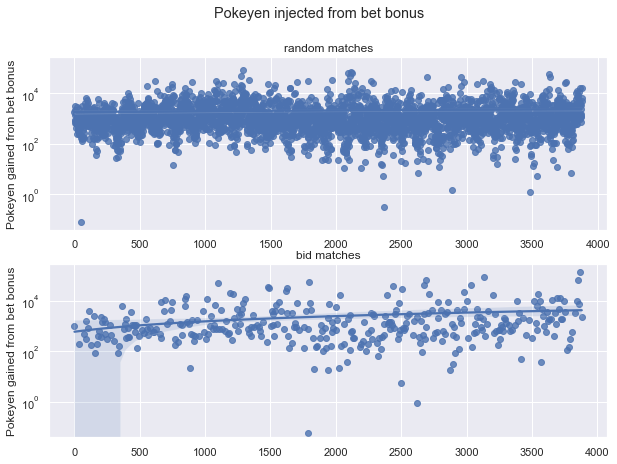

In [21]:
if should_draw_bonus:
    should_draw_random_graph = auto_matches.bet_bonus_amount.mean() > 0
    should_draw_custom_graph = bid_matches.bet_bonus_amount.mean() > 0
    graphs_to_draw = should_draw_random_graph + should_draw_custom_graph
    if graphs_to_draw > 0:
        i = 0

        f, ax = plt.subplots(graphs_to_draw, 1, figsize=(10,7),sharey=True)
        f.suptitle("Pokeyen injected from bet bonus")

        if should_draw_random_graph:
            if graphs_to_draw > 1:
                ax[i].set(yscale="log", title="random matches")
                sns.regplot(x=auto_matches.index,y=auto_matches.bet_bonus_amount, ax=ax[i])
                ax[i].set(ylabel="Pokeyen gained from bet bonus")
                i+=1
            else:
                ax.set(yscale="log", title="random matches")
                sns.regplot(x=auto_matches.index,y=auto_matches.bet_bonus_amount, ax=ax)
                ax.set(ylabel="Pokeyen gained from bet bonus")
        else:
            print("random matches had no bet bonus, skipping drawing graph")

        if should_draw_custom_graph:
            if graphs_to_draw > 1:
                ax[i].set(yscale="log", title="bid matches")
                sns.regplot(x=bid_matches.index,y=bid_matches.bet_bonus_amount, ax=ax[i])
                ax[i].set(ylabel="Pokeyen gained from bet bonus")
            else:
                ax.set(yscale="log", title="bid matches")
                sns.regplot(x=bid_matches.index,y=bid_matches.bet_bonus_amount, ax=ax)
                ax.set(ylabel="Pokeyen gained from bet bonus")
        else:
            print("bid matches had no bet bonus, skipping drawing graph")

        plt.show()

# Match predictability

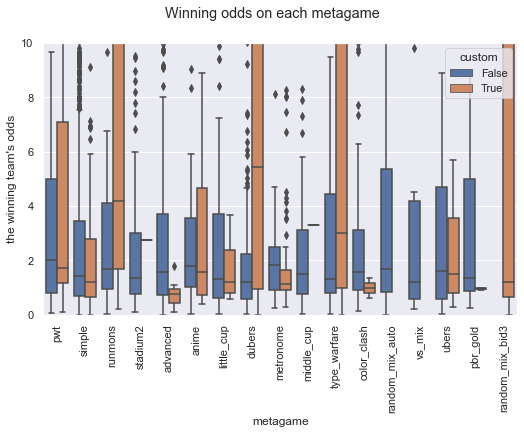

In [22]:
if should_draw_metagames:
    f = plt.figure(figsize=(len(meta.metagame.unique())/2,5))
    f.suptitle("Winning odds on each metagame")
    ax = sns.boxplot(x=meta.metagame,y=meta.winner_odds, hue=meta.custom)
    ax.set(ylabel="the winning team's odds", ylim=(0,10))
    plt.xticks(rotation=90)
    plt.show()

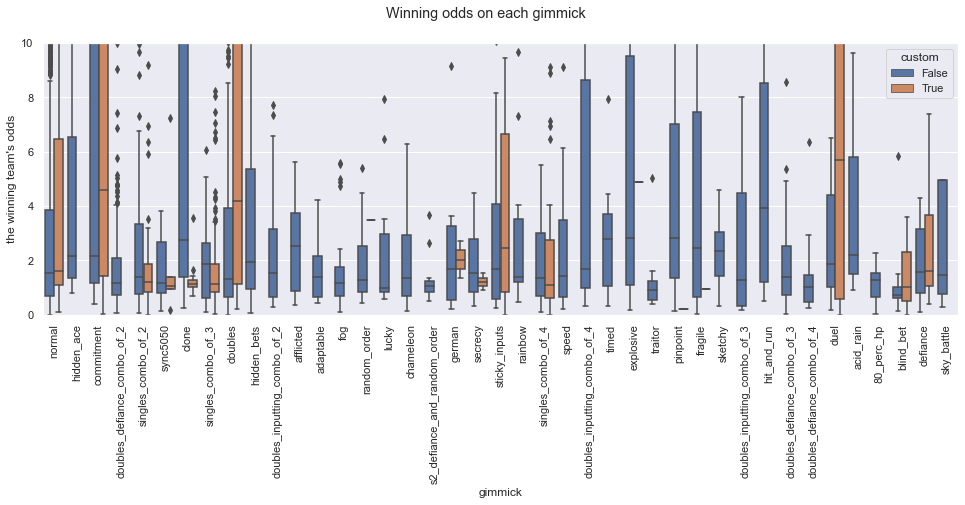

In [23]:
if should_draw_gimmicks:
    f = plt.figure(figsize=(len(gim.gimmick.unique())/2.5,5))
    f.suptitle("Winning odds on each gimmick")
    ax = sns.boxplot(x=gim.gimmick,y=gim.winner_odds, hue=gim.custom)
    ax.set(ylabel="the winning team's odds", ylim=(0,10))
    plt.xticks(rotation=90)
    plt.show()

# Bet Rankings

In [24]:
season = 29
rankings_collection = db.pokeyen_bet_rankings.find({"season": season})
id_to_name_csv = "../user_ids_to_names.csv"

id_to_name_dict: dict
with open(id_to_name_csv, mode="r") as infile:
    reader = csv.reader(infile)
    id_to_name_dict = {rows[0]: rows[1] for rows in reader}
    
ranking = []
for i, a in enumerate(rankings_collection):
    for b in a["ranking"]:
        ranking.append([i,b[0],  id_to_name_dict[b[1]], b[2]])
        
rankings = pd.DataFrame(ranking, columns=["match", "rank", "user_id", "pokeyen"])

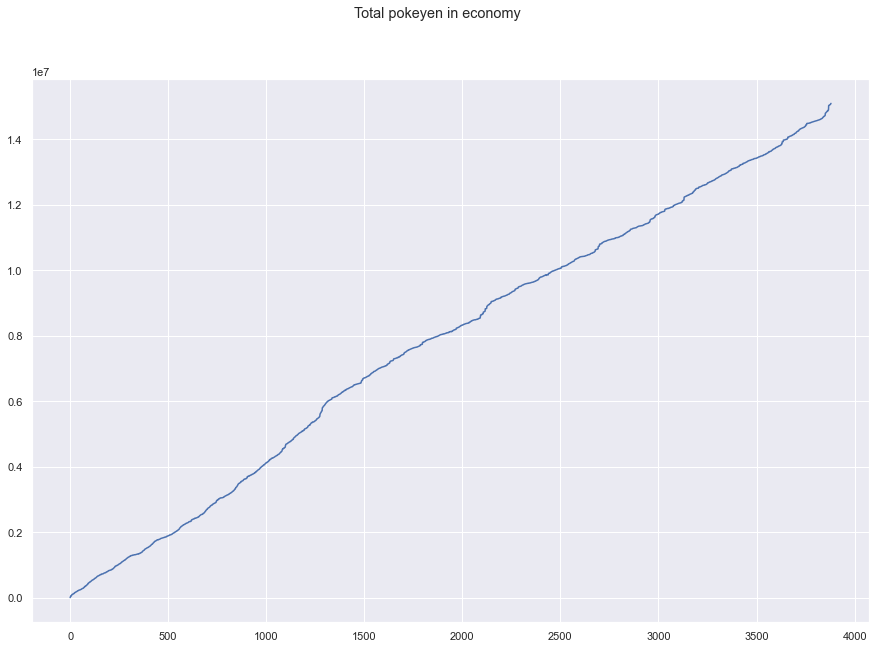

In [25]:
f = plt.figure(figsize=(15,10))
f.suptitle("Total pokeyen in economy")
total_yen = []
for match in rankings.match.unique():
    total_yen.append(rankings[rankings.match == match].pokeyen.sum())
ax = sns.lineplot(data=total_yen)
plt.show()

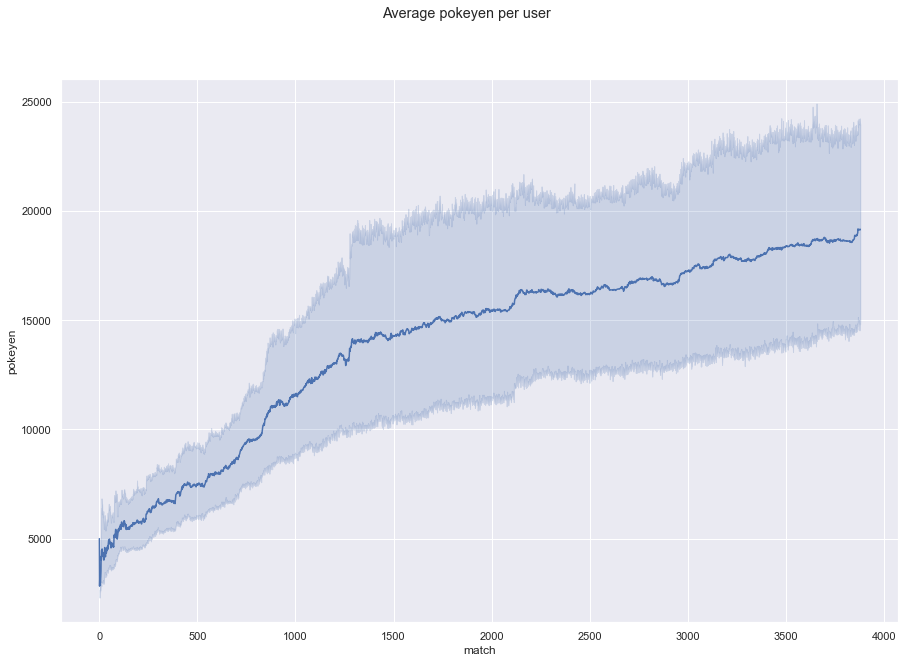

In [26]:
f = plt.figure(figsize=(15,10))
f.suptitle("Average pokeyen per user")
ax = sns.lineplot(x=rankings.match, y=rankings.pokeyen)
plt.show()

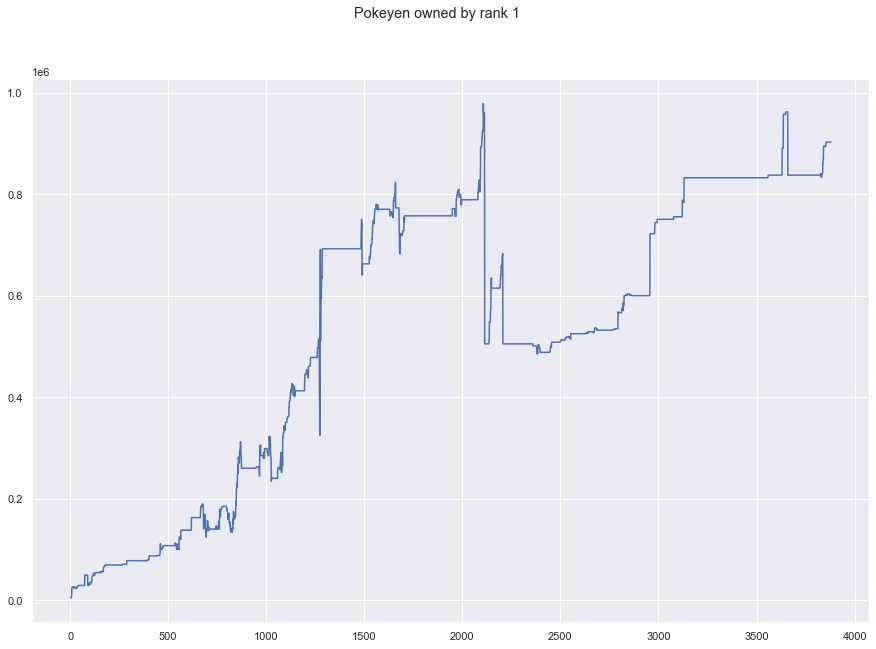

In [27]:
f = plt.figure(figsize=(15,10))
f.suptitle("Pokeyen owned by rank 1")
leader_yen = []
for match in rankings.match.unique():
    leader_yen.append(rankings[rankings.match == match].pokeyen.max())
ax = sns.lineplot(data=leader_yen)
plt.show()

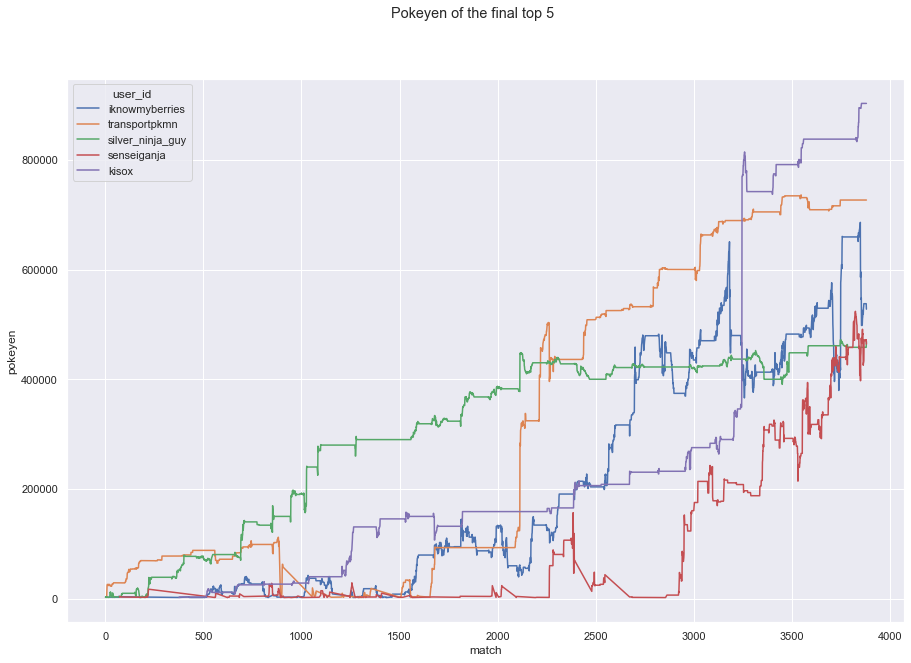

In [28]:
last_match = rankings[rankings.match == rankings.match.max()]
leader_ids = last_match.sort_values("pokeyen").tail(5).user_id.unique()

f = plt.figure(figsize=(15,10))
f.suptitle("Pokeyen of the final top 5")
top5 = rankings[rankings.user_id.isin(leader_ids)]

ax = sns.lineplot(x=top5.match, y=top5.pokeyen, hue=top5.user_id)
plt.show()